# Final Project: Extension 1
# Wooyoung Chung

In [13]:
import gym
import a3_gym_env
import sys

import torch
from torch.optim import Adam
from torch.distributions.normal import Normal
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy
import matplotlib.pyplot as plt
# sample hyperparameters
batch_size = 10000
epochs = 30
learning_rate = 1e-2
hidden_size = 8
n_layers = 2
clipEpsilon = 0.2

In [14]:
class PendulumNN(nn.Module):
    def __init__(self,input,output,activation=nn.Tanh):
        super(PendulumNN,self).__init__()
        self.fc1=nn.Linear(input,90)
        self.fc2=nn.Linear(90,90)
        self.fc3=nn.Linear(90,90)
        self.fc4=nn.Linear(90,output)
        self.act1 = activation
        log_std = -0.5 * numpy.ones(output, dtype=numpy.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        vout = torch.exp(self.log_std)
        return x, vout

In [15]:
class PPOModels():
    def __init__(self,learningRate1,learningRate2):
        self.Actor = PendulumNN(3, 1)
        self.CriticA = PendulumNN(3,1)
        self.CriticB = PendulumNN(3,1)
        self.CriticC = PendulumNN(3,1)
        self.CriticD = PendulumNN(3,1)
        self.CriticE = PendulumNN(3,1)
        self.optimActor = Adam(self.Actor.parameters(), lr=learningRate1)
        self.optimCriticA = Adam(self.CriticA.parameters(), lr=learningRate2)
        self.optimCriticB = Adam(self.CriticB.parameters(), lr=learningRate2)
        self.optimCriticC = Adam(self.CriticC.parameters(), lr=learningRate2)
        self.optimCriticD = Adam(self.CriticD.parameters(), lr=learningRate2)
        self.optimCriticE = Adam(self.CriticE.parameters(), lr=learningRate2)

    # def saveModels(self):
    #     torch.save(self.Actor.state_dict(),"ActorModel.pt")
    #     torch.save(self.Critic.state_dict(),"CriticModel.pt")
    #     torch.save(self.optimActor.state_dict(),"optimActor.pt")
    #     torch.save(self.optimCritic.state_dict(),"optimCritic.pt")

In [16]:
def RewardsToGo(rewards,discountFactor):
    if len(rewards) == 1:
        return rewards
    RewardNext = RewardsToGo(rewards[1:],discountFactor)
    return [rewards[0]+(1-discountFactor)*RewardNext[0]]+RewardNext

In [17]:
def DoRollout(Models,rollout_size,episode_size):
    obervations =[]
    rewards = []
    actions = []
    logprobs = []
    env=gym.make("Pendulum-v1-custom")
    for i in range(rollout_size):
        episodeRewards = []
        obs = env.reset()
        for j in range(episode_size):
            out_mean,out_variance   = Models.Actor(torch.as_tensor(obs))
            out_action_distribution = Normal(out_mean, out_variance)
            action                  = out_action_distribution.sample()
            obervations.append(obs)
            obs, reward, done, info = env.step(action.detach())
            logprob = out_action_distribution.log_prob(action).detach()
            episodeRewards.append(reward.tolist())
            actions.append(action.numpy())
            logprobs.append(logprob)
        rewards.append(episodeRewards)
    return torch.tensor(numpy.array(obervations)),rewards,torch.tensor(numpy.array(actions)),torch.tensor(logprobs)

In [18]:
def getRatio(model,observations,actions,old_logprobs):
    out_mean,out_variance = model.Actor(observations)
    dist = Normal(out_mean, out_variance)
    log_probs = dist.log_prob(actions).squeeze()
    return torch.exp(log_probs-old_logprobs)

In [19]:
def CalculateAdvantage(model,observations,RTG):
    V1 = model.CriticA(observations)[0].detach().squeeze()
    V2 = model.CriticB(observations)[0].detach().squeeze()
    V3 = model.CriticC(observations)[0].detach().squeeze()
    V4 = model.CriticD(observations)[0].detach().squeeze()
    V5 = model.CriticE(observations)[0].detach().squeeze()
    V = (V1+V2+V3+V4+V5)/5
    Advantage = (torch.tensor(RTG)-V)
    return Advantage

def GeneralAdvantage(model,states,rewards,discountFactor):
    if len(rewards)==1:
        return torch.tensor(rewards[0])
    delta = 1-discountFactor
    Vt1 = model.CriticA(states[0])[0].detach().squeeze()
    Vt2 = model.CriticB(states[0])[0].detach().squeeze()
    Vt3 = model.CriticC(states[0])[0].detach().squeeze()
    Vt4 = model.CriticD(states[0])[0].detach().squeeze()
    Vt5 = model.CriticE(states[0])[0].detach().squeeze()
    Vt = (Vt1+Vt2+Vt3+Vt4+Vt5)/5
    VT1 = torch.pow(torch.tensor(delta),len(states)-1)*model.CriticA(states[-1])[0].detach().squeeze()
    VT2 = torch.pow(torch.tensor(delta),len(states)-1)*model.CriticB(states[-1])[0].detach().squeeze()
    VT3 = torch.pow(torch.tensor(delta),len(states)-1)*model.CriticC(states[-1])[0].detach().squeeze()
    VT4 = torch.pow(torch.tensor(delta),len(states)-1)*model.CriticD(states[-1])[0].detach().squeeze()
    VT5 = torch.pow(torch.tensor(delta),len(states)-1)*model.CriticE(states[-1])[0].detach().squeeze()
    VT = (VT1+VT2+VT3+VT4+VT5)/5
    RTG = RewardsToGo(rewards[:len(states)-1],discountFactor)[0]
    return -Vt+RTG+VT

def CalculateGeneralAdvantage(model, obervations,rewards,discountFactor):
    GeneralAdv =[]
    for i in range(len(rewards)):
        obs = obervations[i*len(rewards[0]):(i+1)*len(rewards[0])]
        for j in range(len(rewards[0])):
            GeneralAdv.append(GeneralAdvantage(model,obs[j:],rewards[i][j:],discountFactor))
    return torch.tensor(GeneralAdv)

In [20]:
def PPO(AdvantageType,UsingClip,batchSize,model,rollout=10,episodes =200,clipEpsilon=0.2,df = 0.01):
    batch_size = batchSize
    rollout_size = rollout
    episode_size= episodes
    epsilon= clipEpsilon
    discountFactor = df
    policy = model
    rtg_list = []
    actorGrad_loss_list = []
    criticGrad_loss_list = []
    iter_count = 1
    
    for i in range(batch_size):
        observations,rewards,actions,logprobs = DoRollout(policy,rollout_size,episode_size)
        RTG = []
        for j in range(rollout_size):
            RTG+=RewardsToGo(rewards[j],discountFactor) 
        if AdvantageType=="RTG":
            Advantage = CalculateAdvantage(policy,observations,RTG)
        elif AdvantageType=="GAE":
            Advantage = CalculateGeneralAdvantage(policy,observations,rewards,discountFactor)
        else:
            return "ERROR NO ADV TYPE SPECIFIED"
        iter_count += 1
        rtg_list.append(sum(RTG)/rollout_size)

        for j in range(15):
            ratio = getRatio(policy,observations,actions,logprobs)
            if UsingClip == 1:
                reg =  Advantage*ratio
                clip = torch.clip(ratio, 1 - epsilon, 1 + epsilon) * Advantage
                actorGrad =(-torch.min(reg, clip)).mean()
            else:
                actorGrad = (-(Advantage*ratio)).mean()
            policy.optimActor.zero_grad()
            actorGrad.backward(retain_graph=True)
            policy.optimActor.step()

            V1 = policy.CriticA(observations)[0].squeeze()
            V2 = policy.CriticB(observations)[0].squeeze()
            V3 = policy.CriticC(observations)[0].squeeze()
            V4 = policy.CriticD(observations)[0].squeeze()
            V5 = policy.CriticE(observations)[0].squeeze()
            criticGrad = nn.MSELoss()(V1, torch.tensor(RTG))
            policy.optimCriticA.zero_grad()
            criticGrad.backward()
            policy.optimCriticA.step()
            criticGrad = nn.MSELoss()(V2, torch.tensor(RTG))
            policy.optimCriticB.zero_grad()
            criticGrad.backward()
            policy.optimCriticB.step()
            criticGrad = nn.MSELoss()(V3, torch.tensor(RTG))
            policy.optimCriticC.zero_grad()
            criticGrad.backward()
            policy.optimCriticC.step()
            criticGrad = nn.MSELoss()(V4, torch.tensor(RTG))
            policy.optimCriticD.zero_grad()
            criticGrad.backward()
            policy.optimCriticD.step()
            criticGrad = nn.MSELoss()(V5, torch.tensor(RTG))
            policy.optimCriticE.zero_grad()
            criticGrad.backward()
            policy.optimCriticE.step()
            
            if j ==14:
                actorGrad_loss_list.append(actorGrad.item())
                criticGrad_loss_list.append(criticGrad.item())
    #     policy.saveModels() 

    # policy.saveModels()
    print("Finished!")
    return policy, rtg_list, actorGrad_loss_list, criticGrad_loss_list, rewards

In [21]:
def TryModel(model):
    env=gym.make("Pendulum-v1-custom")
    obs = env.reset()
#     rewards=[]
#     # print(obs)
#     minReward = -1000
#     minobs = obs
    # print(obs)
    thetaLst = [np.arccos(obs[0])]
    thetaDotLst = [obs[2]]
    
    for i in range(1000):
        action,_ = model(torch.tensor(obs))
        obs, reward, done, info = env.step(action.detach())
        thetaLst.append(np.arccos(obs[0]))
        thetaDotLst.append(obs[2])
#         if reward > minReward:
#             minReward=reward
#             minobs = obs
#         rewards.append(reward.tolist())
    return thetaLst, thetaDotLst

In [22]:
def Environment(AdvantageType,Clip,batch_size,Rollout=10,episodes =200,clipEpsilon=0.2,df = 0.01,lr1=1e-2,lr2=1e-2):
    Model = PPOModels(lr1,lr2)
    return PPO(AdvantageType,Clip,batch_size,Model,Rollout,episodes,clipEpsilon,df)

In [23]:
def visualize_matrix(model):
    # save to a matrix
    matrx = [] # will end up being a 100 by 100 matrix t
    theta = -np.pi
    thetaDot = 8
    count = 0
    for i in range(100):
        tmp_matrix = []
        theta = -np.pi
        # after first iteration need to shift thetaDot down
        if count > 0:
            thetaDot = thetaDot - ((2*8)/100)
        for j in range(100):
            tmp_matrix.append(model.Critic(torch.tensor([np.float32(np.cos(theta)),np.float32(np.sin(theta)),thetaDot]))[0].item())
            # shift theta to the right
            theta = theta + ((2*np.pi)/100)
        matrx.append(tmp_matrix)
        count +=1

    plt.imshow(matrx)
    plt.colorbar()
    plt.show()

model, rtg_list, actorGrad_loss_list, criticGrad_loss_list, rewards = Environment("GAE",1,400,10,200,0.2,0.05,0.0003,0.0003)

In [24]:
model, rtg_list, actorGrad_loss_list, criticGrad_loss_list, rewards = Environment("GAE",1,400,10,200,0.2,0.05,0.0003,0.0003)

Finished!


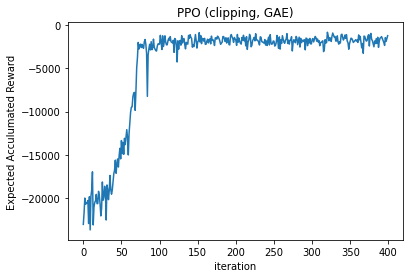

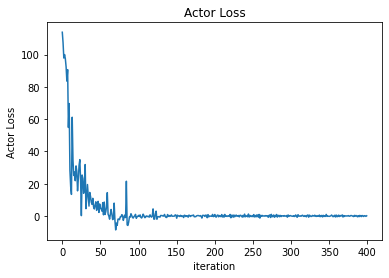

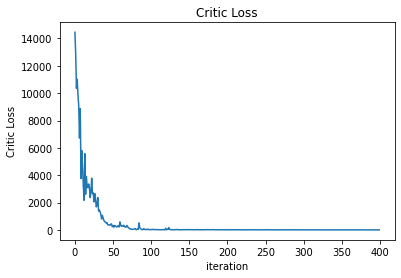

In [25]:
# plot rtg_list
plt.plot(rtg_list)
plt.title("PPO (clipping, GAE)")
plt.xlabel("iteration")
plt.ylabel("Expected Acculumated Reward")
plt.show()
# plot actorGrad_loss_list
plt.plot(actorGrad_loss_list)
plt.title("Actor Loss")
plt.xlabel("iteration")
plt.ylabel("Actor Loss")
plt.show()
# plot criticGrad_loss_list
plt.plot(criticGrad_loss_list)
plt.title("Critic Loss")
plt.xlabel("iteration")
plt.ylabel("Critic Loss")
plt.show()

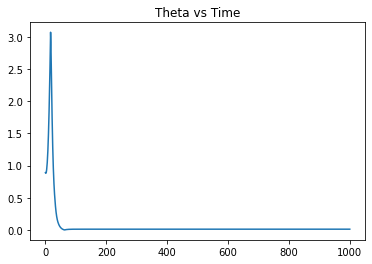

In [26]:
plt.title("Theta vs Time")
plt.plot(TryModel(model.Actor)[0])
plt.show()

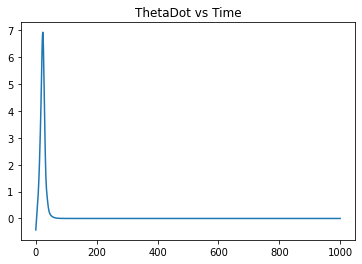

In [27]:
plt.title("ThetaDot vs Time")
plt.plot(TryModel(model.Actor)[1])
plt.show()

# Discussion
In this work, we used an ensemble of critics in the PPO algorithm. From this, the learning was a lot more stable and successfully/efficiently learned the task.